Loaded 500 samples from ECG5000/ECG5000_TRAIN.ts
Loaded 4500 samples from ECG5000/ECG5000_TEST.ts
Number of classes: 5
y_train unique labels: [0 1 2 3 4]
y_test unique labels: [0 1 2 3 4]
x_train shape: (500, 139)
y_train shape: (500,)
x_test shape: (4500, 139)
y_test shape: (4500,)
Original class distribution: Counter({0: 292, 1: 177, 3: 19, 2: 10, 4: 2})
Resampled class distribution: Counter({0: 292, 1: 292, 2: 292, 3: 292, 4: 292})


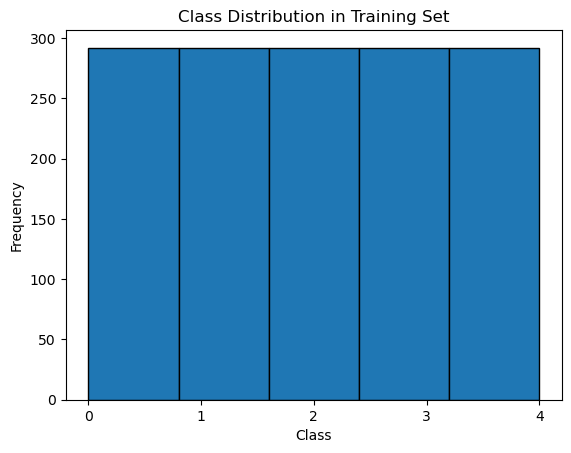

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50] | Loss: 1.6147, Training accuracy: 23.42%
Test Accuracy after Epoch 1: 4.71%
Epoch [2/50] | Loss: 1.5137, Training accuracy: 34.66%
Test Accuracy after Epoch 2: 83.76%
Epoch [3/50] | Loss: 1.4142, Training accuracy: 47.95%
Test Accuracy after Epoch 3: 60.73%
Epoch [4/50] | Loss: 1.2962, Training accuracy: 58.97%
Test Accuracy after Epoch 4: 73.07%
Epoch [5/50] | Loss: 1.1446, Training accuracy: 61.78%
Test Accuracy after Epoch 5: 59.98%
Epoch [6/50] | Loss: 1.0286, Training accuracy: 66.30%
Test Accuracy after Epoch 6: 83.80%
Epoch [7/50] | Loss: 0.9580, Training accuracy: 68.63%
Test Accuracy after Epoch 7: 72.91%
Epoch [8/50] | Loss: 0.9321, Training accuracy: 68.08%
Test Accuracy after Epoch 8: 56.20%
Epoch [9/50] | Loss: 0.8984, Training accuracy: 70.00%
Test Accuracy after Epoch 9: 58.07%
Epoch [10/50] | Loss: 0.8631, Training accuracy: 71.16%
Test Accuracy after Epoch 10: 81.09%
Epoch [11/50] | Loss: 0.8447, Training accuracy: 70.75%
Test Accuracy after Epoch 11: 78.

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Read UCR Dataset
def read_ucr(filename):
    data = []
    labels = []
    
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) < 2:  # Ensure there's at least one feature and one label
                continue
            features = [float(f) for f in parts[:-1]]
            label = int(parts[-1].split(':')[-1])  # Handle label after the colon
            data.append(features)
            labels.append(label)
    
    print(f"Loaded {len(data)} samples from {filename}")
    return np.array(data), np.array(labels)

train_file = 'ECG5000/ECG5000_TRAIN.ts'
test_file = 'ECG5000/ECG5000_TEST.ts'

# Load dataset
x_train, y_train = read_ucr(train_file)
x_test, y_test = read_ucr(test_file)

# Normalize labels to be within range [0, num_classes-1]
unique_labels = np.unique(y_train)
label_map = {label: idx for idx, label in enumerate(unique_labels)}
y_train = np.array([label_map[label] for label in y_train])
y_test = np.array([label_map[label] for label in y_test])

nb_classes = len(unique_labels)

# Verify labels are within range
print(f"Number of classes: {nb_classes}")
print(f"y_train unique labels: {np.unique(y_train)}")
print(f"y_test unique labels: {np.unique(y_test)}")

# Ensure labels are within the expected range [0, num_classes-1]
assert y_train.min() >= 0 and y_train.max() < nb_classes, "Train labels are out of range"
assert y_test.min() >= 0 and y_test.max() < nb_classes, "Test labels are out of range"

# Print shapes to ensure they match
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Apply SMOTE to the training data
from collections import Counter

print(f"Original class distribution: {Counter(y_train)}")
smote = SMOTE(k_neighbors=1)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
print(f"Resampled class distribution: {Counter(y_train_resampled)}")


# Convert to PyTorch tensors
X_train = torch.tensor(x_train_resampled, dtype=torch.float32).unsqueeze(-1)  # Add feature dimension
X_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train_resampled, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create Data Loaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Plot class distribution
plt.hist(y_train.numpy(), bins=nb_classes, edgecolor='k')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(nb_classes))
plt.show()

# Define the Transformer model
class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, dim_model=64, num_heads=8, num_layers=2, dropout=0.1):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, dim_model)
        self.position_encoding = nn.Parameter(torch.zeros(1, 200, dim_model))  # Adjust to the expected max sequence length
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_model, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(dim_model, num_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        seq_len = x.size(1)  # Get the actual sequence length of the input
        x = self.embedding(x)
        x += self.position_encoding[:, :seq_len, :]  # Adjust positional encoding to match the input sequence length
        x = x.permute(1, 0, 2)  # Transformer expects input of shape (seq_len, batch, dim_model)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Initialize the Transformer model
input_dim = 1  # Since each time step has a single feature
dim_model = 64
num_heads = 8
num_layers = 2
dropout = 0.1
num_classes = nb_classes
model = SimpleTransformer(input_dim, num_classes, dim_model, num_heads, num_layers, dropout).to(device)


# Initialize the Transformer model
input_dim = 1  # Since each time step has a single feature
dim_model = 32
num_heads = 2
num_layers = 1
dropout = 0.1
num_classes = nb_classes
model = SimpleTransformer(input_dim, num_classes, dim_model, num_heads, num_layers, dropout).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Training loop with early stopping
num_epochs = 50
best_test_accuracy = 0
patience = 10
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    if epoch % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f}, Training accuracy: {epoch_accuracy:.2f}%')

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total

    if epoch % 1 == 0:
        print(f'Test Accuracy after Epoch {epoch+1}: {test_accuracy:.2f}%')
    scheduler.step()

    # Check for early stopping
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

print(f'Best Test Accuracy: {best_test_accuracy:.2f}%')
